# AMS 526 Homework 2 
**submitted by Jiaxi Zhao on 23th Sep, 2020**

In this notebook we run some experiments to numerically calculate the condition number of
a real matrix $A$ using 1-norm. This is divided into two parts, 
- calculation of $\left\| A \right\|_1$
- calculation of $\left\| A^{-1} \right\|_1$


The first calculation is simple and we focus on the second calculation.

By the vector-norm induced definition of matrix norm, one has that $\left\| A^{-1} \right\|_1 = \sup_{\left\| x \right\|_1 = 1}\left\| A^{-1}x \right\|_1$. One can estimate $\left\| A^{-1} \right\|_1$ as $\frac{\left\| z \right\|_1}{\left\| y \right\|_1}$, where $y = Az$ and $y$ is some specially chosen vector in order to make $z$ has 1-norm as large as possible. In our experiment, the vector $y$ is chosen by solving an auxilliary equation $A^Ty = c$. The detailed formulation will be discussed in the next section.

## Implementation and test

In [177]:
import numpy as np
from matplotlib import pyplot as plt 
from time import time
from scipy.linalg import lu as lu
import scipy.linalg as alg
from scipy.linalg import solve_triangular as st
from scipy.linalg import solve as ss

Generate the data: $A \in \mathbb{R}^{n \times n}$.

In [205]:
n   = 10
A   = np.random.rand(n, n)

We discuss the formulation and implementation to choose the vector $y$ now. It is taken to be the solution of the equation $A^Ty = c$, where $c$ is a vector with all of its elements $1$ or $-1$. To solve this equation, we first apply pivoted LU factorization to $A$, i.e. $A = PLU$, where $P$ is a permutation matrix, $U$ is an upper triangular matrix, and $L$ is an lower triangular matrix. Similar to classical linear system solvers, $A^Ty = c$ is solved via 
\begin{equation}
    U^T L^T P^T y = c \Longrightarrow U^T v = c, L^T P^T y = v.
\end{equation}
\begin{remark}
    The idea here is that any ill-conditioning in $A$ will be reflected in $U$, resulting in a relatively large $v$. The relative well-conditioning unit triangular matrix $L$ will then preserve this relationship, resulting in relatively large $y$.
\end{remark}

In [206]:
def Cond_my(A):
    c   = np.zeros([n, 1])
    v   = np.zeros([n, 1])
    P, L, U  = lu(A)
    for i in range(n):
        sum  = U[:, i].dot(v)
        c[i] = - np.sign(sum)
        if (sum == 0):
            c[i] = 1
        v[i] = (c[i] - sum) / U[i, i]

    Py       = st(L.T, v)
    y        = ss(P.T, Py)
    LUz      = ss(P, y)
    Uz       = st(L, LUz, lower = True)
    z        = st(U, Uz)
    My_cond  = alg.norm(z, 1)/alg.norm(y, 1) * alg.norm(A, 1)
    #print('Approximated condition number: ', My_cond)
    #print('exact condition number: ', cond)
    return My_cond

In [207]:
print(Cond_my(A))
print(alg.norm(alg.inv(A), 1) * alg.norm(A, 1))

221.28333080964458
285.0630685246844


## Analysis of the numbers of floating-point operations

In this part, we theoretically analysis the numbers of floating-point operations of our approximating algorithms. 

The first part is a LU factorization, which has complexity $\sum_{i = 1}^n 2(n - i)(n - i + 1) = \frac{2}{3}n^3 - \frac{2}{3}n$. One can avoid the calculation of transpose of $U$ by changing the two indices each time. In the next step, we calculate the vector $c, v$. The total FLOP to fix $c[i], v[i]$ is given by $2(i - 1) - 1 + 3$. The last $3$ FLOPs can also be $2$, which does not matter. Hence one have $\sum_{i = 1}^n 2(i - 1) + 2n = n^2 + n$ (FLOPs). After that, we will solve the linear system $L^T P^T y = v$. Since $L$ is lower triangular and $P$ is a permutation matrix, this can be done with $n + \sum_{i = 1}^n 2(i - 1) = n^2$. Last, we solve $y = Az$ by leveraging the previous LU decomposition, which takes $2n^2$ FLOPs. The total FLOPs is thus given by $\frac{2}{3}n^3 + 5n^2 + \frac{1}{3}n$
Summarize the above analysis as follows:
\begin{itemize}
    \item LU factorization: $\frac{2}{3}n^3 - \frac{2}{3}n$;
    \item Find v: $n^2 + n$;
    \item Compute y: $n^2$;
    \item Compute z: $2n^2$;
    \item Calculate $\left\| A \right\|_1$: $n^2$.
\end{itemize}

The direct calculation of the inverse matrix of $A$ is given by $\frac{2}{3}n^3 - \frac{2}{3}n + n^3 + 2n^2 = \frac{5}{3}n^3 + 2n^2 - \frac{2}{3}n$ FLOPs. Where the first part is LU decomposition, the second part is multiplication of $U^{-1}, L^{-1}$ and the last part is calculating the inverse of $L, U$.

## Numerical experiments
We compare the performance of two algorithms on problems of difference sizes. The running time is obtained under several repeated experiments and taking the average. 

In [209]:
cond_arr = np.zeros([11, 2])
for n in range(2, 13):
    X = 1. / (np.arange(1, n + 1) + np.arange(0, n)[:, np.newaxis])
    cond_arr[n - 2, 0] = Cond_my(X)
    cond_arr[n - 2, 1] = alg.norm(alg.inv(X), 1) * alg.norm(X, 1)

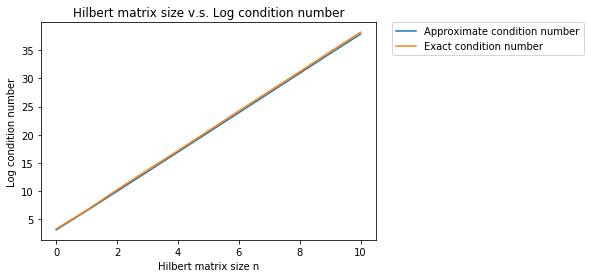

In [210]:
plt.title("Hilbert matrix size v.s. Log condition number") 
plt.xlabel("Hilbert matrix size n") 
plt.ylabel("Log condition number") 
plt.plot(np.log(cond_arr[:, 0]), label = "Approximate condition number")
plt.plot(np.log(cond_arr[:, 1]), label = "Exact condition number")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

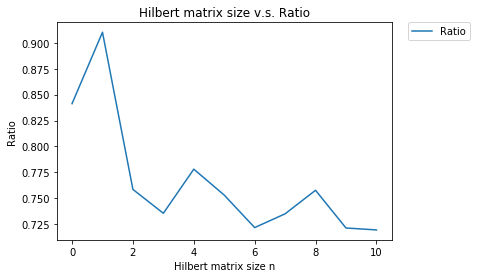

In [211]:
plt.title("Hilbert matrix size v.s. Ratio") 
plt.xlabel("Hilbert matrix size n") 
plt.ylabel("Ratio") 
plt.plot(cond_arr[:, 0] / cond_arr[:, 1], label ="Ratio")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

We first plot the calculation of condition number in approximated algorithm and exact calculation by exact formula. 

To further explore the connection between numerical experiments and theoretic analysis in previous part, we plot the ratio between the empirical running times and theoretic running times under different problem sizes. It can be concluded from the results that the approximated condition number is in general $[0.7, 0.9]$ of the real condition number, which can be thought as a good approximation.

In [212]:
time_arr = np.zeros([11, 2])
num = 1000
for n in range(2, 13):
    X = 1. / (np.arange(1, n + 1) + np.arange(0, n)[:, np.newaxis])
    time1    = 0
    time2    = 0
    for i in range(num):
        start = time()
        Cond_my(X)
        time1 = time1 + time() - start
        start = time()
        cnum  = alg.norm(alg.inv(X), 1) * alg.norm(X, 1)
        time2 = time2 + time() - start
    time_arr[n - 2, 0] = time1/num
    time_arr[n - 2, 1] = time2/num   

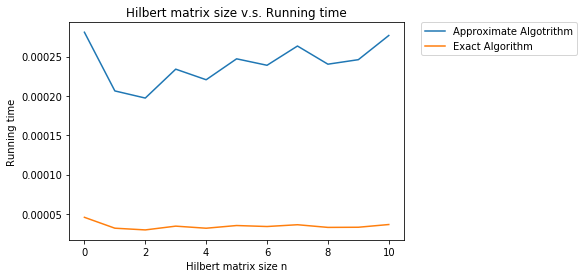

In [215]:
plt.title("Hilbert matrix size v.s. Running time") 
plt.xlabel("Hilbert matrix size n") 
plt.ylabel("Running time") 
plt.plot(time_arr[:, 0], label = "Approximate Algotrithm")
plt.plot(time_arr[:, 1], label = "Exact Algorithm")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

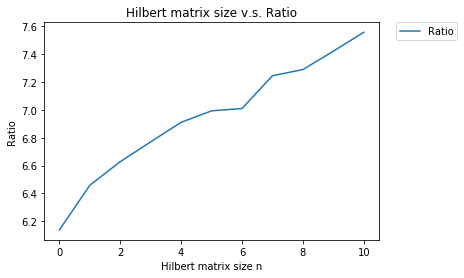

In [216]:
plt.title("Hilbert matrix size v.s. Ratio") 
plt.xlabel("Hilbert matrix size n") 
plt.ylabel("Ratio") 
plt.plot(time_arr[:, 0] / time_arr[:, 1], label ="Ratio")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.show()

\begin{remark}
    First, it is disappointing that our approximate algorithm indeed perform worse than the exact calculation. It can also be concluded from the above figure that the ratio increases with the problem sizes. This is an illustration that our hand-written algorithm does not have good scalability.
\end{remark}

\begin{remark}
In general, the empirical and theoretic ratio does not coincide, which is another facet of the weird phenomenon we come across in the previous figure. This may caused by some hidden constant on the FLOP.
\end{remark}

## Conclusion
We conduct numerical experiments on an approximated algorithms concerned with condition number of matrix. The numerical results are compared with the theoretic analysis from different perspectives. The performance of the approximate algorithm is kind of appealing while its time consumption is not that attractive.